In [13]:
"""
XAS Spectra PCA + Clustering Pipeline
======================================
Reads pre-normalized XANES/EXAFS spectra, performs PCA to identify
the number of distinct spectral components, then clusters spectra
in PC-score space to group similar grains.

Assumes spectra are already normalized/flattened (e.g., via Athena or Larch).
Uses the flattened (post-edge-corrected) XANES by default to avoid
post-edge slope artifacts in PCA.

Requirements:
    pip install xraylarch scikit-learn scipy matplotlib numpy pandas

Usage:
    1. Update the CONFIGURATION section below with your paths and parameters.
    2. Run: python xas_pca_clustering.py
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from pathlib import Path
import pandas as pd

# Larch imports
from larch import Group
from larch.math import pca_train

'\nXAS Spectra PCA + Clustering Pipeline\n======================================\nReads pre-normalized XANES/EXAFS spectra, performs PCA to identify\nthe number of distinct spectral components, then clusters spectra\nin PC-score space to group similar grains.\n\nAssumes spectra are already normalized/flattened (e.g., via Athena or Larch).\nUses the flattened (post-edge-corrected) XANES by default to avoid\npost-edge slope artifacts in PCA.\n\nRequirements:\n    pip install xraylarch scikit-learn scipy matplotlib numpy pandas\n\nUsage:\n    1. Update the CONFIGURATION section below with your paths and parameters.\n    2. Run: python xas_pca_clustering.py\n'

In [14]:
# ============================================================
# CONFIGURATION
# ============================================================

# Directory containing your normalized spectra files
SPECTRA_DIR = Path("./flattened-spectra")

# Energy range to use for PCA (eV, relative to E0 or absolute)
# Set to None to use the full overlapping range
E_MIN = 7100  # e.g., -20 (relative to E0) or 7100 (absolute)
E_MAX = 7180  # e.g., 80 (relative to E0) or 7200 (absolute)
ENERGY_IS_RELATIVE = False  # True if E_MIN/E_MAX are relative to E0

# PCA region: 'xanes' uses normalized mu(E), 'exafs' uses chi(k)
PCA_REGION = "xanes"

# Common energy/k grid spacing for interpolation
E_STEP = 0.2  # eV step for XANES

# Max number of clusters to evaluate
MAX_CLUSTERS = 15

# Set to None to use silhouette-optimal k, or an integer to override
FORCE_K = 4

# Number of PCA components to use for clustering and target transformation.
# Set to None to use the IND minimum (automatic), or override with an integer
# if IND gives an unreasonable result (common with noisy microprobe data).
N_COMPONENTS = 4

# Reference spectra for target transformation (optional)
# List of file paths to reference spectra
REFERENCE_DIR = Path("./FeK-standards/fluorescence/flattened")
REFERENCE_FILES = ["2L-Fhy on sand.csv",
                    "2L-Fhy.csv",
                    "6L-Fhy.csv",
                    "Augite.csv",
                    "Biotite.csv",
                    "FeS.csv",
                    "Ferrosmectite.csv",
                    "Goethite on sand.csv",
                    "Goethite.csv",
                    "Green Rust - Carbonate.csv",
                    "Green Rust - Chloride.csv",
                    "Green Rust - Sulfate.csv",
                    "Hematite on sand.csv",
                    "Hematite.csv",
                    "Hornblende.csv",
                    "Ilmenite.csv",
                    "Jarosite.csv",
                    "Lepidocrocite.csv",
                    "Mackinawite (aged).csv",
                    "Mackinawite.csv",
                    "Maghemite.csv",
                    "Nontronite.csv",
                    "Pyrite.csv",
                    "Pyrrhotite.csv",
                    "Schwertmannite.csv",
                    "Siderite-n.csv",
                    "Siderite-s.csv",
                    "Vivianite.csv"] 
                    
REFERENCE_PATHS = [REFERENCE_DIR / f for f in REFERENCE_FILES]
# Output directory
OUTPUT_DIR = Path("./pca_results")

In [15]:
def load_ascii_spectra(spectra_dir, pattern="*.csv"):
    """
    Load pre-normalized/flattened spectra from individual CSV files.
    Expected format: comment lines starting with #, then two columns
    (energy, flat) comma-separated.
    """
    groups = []
    files = sorted(Path(spectra_dir).glob(pattern))
    for f in files:
        try:
            data = np.loadtxt(str(f), delimiter=",", comments="#")
            g = Group(
                energy=data[:, 0],
                flat=data[:, 1],
                filename=f.stem,
                _name=f.stem,
            )
            groups.append(g)
        except Exception as e:
            print(f"  Skipping {f.name}: {e}")
    print(f"Loaded {len(groups)} spectra from {spectra_dir}")
    return groups


In [16]:
def build_xanes_matrix(groups, e_min=None, e_max=None):
    """
    Interpolate normalized XANES spectra onto a common energy grid.
    Returns: energy_grid (1D), matrix (n_spectra x n_energy), names list
    """
    # Find the common energy range
    all_emin = max(g.energy.min() for g in groups)
    all_emax = min(g.energy.max() for g in groups)

    if e_min is not None:
        if ENERGY_IS_RELATIVE:
            # Use median E0 as reference
            e0_median = np.median([g.e0 for g in groups])
            all_emin = max(all_emin, e0_median + e_min)
        else:
            all_emin = max(all_emin, e_min)

    if e_max is not None:
        if ENERGY_IS_RELATIVE:
            e0_median = np.median([g.e0 for g in groups])
            all_emax = min(all_emax, e0_median + e_max)
        else:
            all_emax = min(all_emax, e_max)

    energy_grid = np.arange(all_emin, all_emax, E_STEP)
    matrix = np.zeros((len(groups), len(energy_grid)))
    names = []

    for i, g in enumerate(groups):
        matrix[i, :] = np.interp(energy_grid, g.energy, g.flat)
        names.append(g._name)

    print(f"Spectral matrix: {matrix.shape[0]} spectra × {matrix.shape[1]} energy points")
    print(f"Energy range: {energy_grid[0]:.1f} – {energy_grid[-1]:.1f} eV")
    return energy_grid, matrix, names

In [17]:
# ============================================================
# QUALITY SCREENING
# ============================================================

def screen_spectra(matrix, names, sigma_threshold=3.0):
    """
    Remove outlier spectra based on their distance from the mean spectrum.
    Returns filtered matrix and names.
    """
    mean_spec = matrix.mean(axis=0)
    distances = np.sqrt(np.sum((matrix - mean_spec) ** 2, axis=1))
    threshold = distances.mean() + sigma_threshold * distances.std()

    mask = distances < threshold
    n_removed = (~mask).sum()
    if n_removed > 0:
        print(f"Quality screen: removed {n_removed} spectra beyond {sigma_threshold}σ")
        removed_names = [names[i] for i in range(len(names)) if not mask[i]]
        for rn in removed_names:
            print(f"    Removed: {rn}")
    else:
        print("Quality screen: all spectra passed")

    filtered_names = [names[i] for i in range(len(names)) if mask[i]]
    return matrix[mask], filtered_names, mask

In [18]:
# ============================================================
# PCA
# ============================================================

def run_pca(x_grid, matrix, names):
    """
    Run PCA using Larch's pca_train.
    Returns the PCA result group.
    """
    # Build Larch groups for pca_train
    groups_for_pca = []
    for i in range(matrix.shape[0]):
        g = Group()
        if PCA_REGION == "xanes":
            g.energy = x_grid
            g.flat = matrix[i, :]
        else:
            g.k = x_grid
            g.chi = matrix[i, :] / (x_grid ** K_WEIGHT)  # undo k-weight
        g._name = names[i]
        groups_for_pca.append(g)

    if PCA_REGION == "xanes":
        pca_result = pca_train(groups_for_pca, arrayname="flat")
    else:
        pca_result = pca_train(groups_for_pca, arrayname="chi")

    return pca_result


def plot_pca_diagnostics(pca_result, output_dir):
    """Plot scree plot, IND, and component spectra."""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    n_show = min(20, len(pca_result.variances))

    # --- Scree plot ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(range(1, n_show + 1), pca_result.variances[:n_show], "ko-")
    ax1.set_xlabel("Component number")
    ax1.set_ylabel("Eigenvalue (variance)")
    ax1.set_title("Scree Plot")
    ax1.set_xticks(range(1, n_show + 1))
    ax1.grid(True, alpha=0.3)

    # --- IND function ---
    ax2 = fig.add_subplot(gs[0, 1])
    ind = pca_result.ind
    ax2.semilogy(range(1, len(ind) + 1), ind, "rs-")
    ind_min = np.argmin(ind) + 1
    ax2.axvline(ind_min, color="blue", linestyle="--", label=f"IND min = {ind_min}")
    ax2.set_xlabel("Component number")
    ax2.set_ylabel("IND")
    ax2.set_title(f"Indicator Function (minimum at {ind_min} components)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # --- First few component spectra ---
    ax3 = fig.add_subplot(gs[1, 0])
    n_comp_show = min(5, ind_min + 2)
    for i in range(n_comp_show):
        offset = i * 0.5
        ax3.plot(pca_result.components[i] + offset, label=f"PC{i+1}")
    ax3.set_xlabel("Point index")
    ax3.set_ylabel("Component loading (offset)")
    ax3.set_title("Principal Component Spectra")
    ax3.legend(fontsize=8)

    # --- Cumulative variance ---
    ax4 = fig.add_subplot(gs[1, 1])
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances) * 100
    ax4.plot(range(1, n_show + 1), cumvar[:n_show], "go-")
    ax4.axhline(95, color="red", linestyle="--", alpha=0.5, label="95%")
    ax4.axhline(99, color="red", linestyle=":", alpha=0.5, label="99%")
    ax4.set_xlabel("Number of components")
    ax4.set_ylabel("Cumulative variance (%)")
    ax4.set_title("Cumulative Variance Explained")
    ax4.legend()
    ax4.set_xticks(range(1, n_show + 1))
    ax4.grid(True, alpha=0.3)

    plt.savefig(output_dir / "pca_diagnostics.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: pca_diagnostics.png")
    return ind_min

In [19]:
# ============================================================
# CLUSTERING
# ============================================================

def evaluate_kmeans(scores, max_k):
    """Evaluate k-means for different numbers of clusters."""
    results = {"k": [], "inertia": [], "silhouette": []}
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(scores)
        results["k"].append(k)
        results["inertia"].append(km.inertia_)
        results["silhouette"].append(silhouette_score(scores, labels))
    return results


def run_clustering(scores, names, n_components, output_dir):
    """
    Run k-means and hierarchical clustering on PCA scores.
    Produces diagnostic plots and returns cluster assignments.
    """
    max_k = min(MAX_CLUSTERS, len(names) - 1)

    # --- Evaluate k-means ---
    km_results = evaluate_kmeans(scores, max_k)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Elbow plot
    axes[0].plot(km_results["k"], km_results["inertia"], "ko-")
    axes[0].set_xlabel("Number of clusters (k)")
    axes[0].set_ylabel("Inertia (within-cluster SS)")
    axes[0].set_title("K-Means Elbow Plot")
    axes[0].grid(True, alpha=0.3)

    # Silhouette plot
    axes[1].plot(km_results["k"], km_results["silhouette"], "bs-")
    best_k = km_results["k"][np.argmax(km_results["silhouette"])]
    axes[1].axvline(best_k, color="red", linestyle="--",
                    label=f"Best k = {best_k}")
    axes[1].set_xlabel("Number of clusters (k)")
    axes[1].set_ylabel("Silhouette score")
    axes[1].set_title("Silhouette Analysis")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_dir / "kmeans_evaluation.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: kmeans_evaluation.png")
    print(f"Optimal k by silhouette: {best_k}")

    # --- Hierarchical clustering dendrogram ---
    linkage_matrix = linkage(pdist(scores, metric="euclidean"), method="ward")

    fig, ax = plt.subplots(figsize=(16, 8))
    dendrogram(
        linkage_matrix,
        labels=names,
        leaf_rotation=90,
        leaf_font_size=6,
        ax=ax,
    )
    ax.set_title("Hierarchical Clustering Dendrogram (Ward linkage)")
    ax.set_ylabel("Distance")
    plt.tight_layout()
    plt.savefig(output_dir / "dendrogram.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: dendrogram.png")

    # --- Score scatter plots with cluster assignments ---
    km_best = KMeans(n_clusters=best_k, n_init=20, random_state=42)
    labels = km_best.fit_predict(scores)

    n_pairs = min(3, n_components - 1)
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
    if n_pairs == 1:
        axes = [axes]

    pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
    for ax, (i, j) in zip(axes, pc_pairs):
        scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                             cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
        ax.set_xlabel(f"PC{i+1} score")
        ax.set_ylabel(f"PC{j+1} score")
        ax.set_title(f"PC{i+1} vs PC{j+1}")
        ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[-1], label="Cluster")
    plt.tight_layout()
    plt.savefig(output_dir / "score_scatter.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: score_scatter.png")

    return labels, best_k, km_best

In [20]:
# ============================================================
# CLUSTER INSPECTION
# ============================================================

def plot_cluster_spectra(x_grid, matrix, names, labels, n_clusters, output_dir):
    """Plot all spectra in each cluster, plus cluster centroids."""
    xlabel = "Energy (eV)" if PCA_REGION == "xanes" else f"k (Å⁻¹)"

    # Individual cluster plots
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5),
                             sharey=True)
    if n_clusters == 1:
        axes = [axes]

    centroids = []
    for ci in range(n_clusters):
        mask = labels == ci
        cluster_spectra = matrix[mask]
        centroid = cluster_spectra.mean(axis=0)
        centroids.append(centroid)
        cluster_names = [names[i] for i in range(len(names)) if mask[i]]

        ax = axes[ci]
        for spec in cluster_spectra:
            ax.plot(x_grid, spec, alpha=0.3, color=f"C{ci}")
        ax.plot(x_grid, centroid, "k-", linewidth=2, label="Centroid")
        ax.set_xlabel(xlabel)
        ax.set_title(f"Cluster {ci+1} (n={mask.sum()})")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_spectra.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_spectra.png")

    # Overlay of all centroids
    fig, ax = plt.subplots(figsize=(8, 6))
    for ci, centroid in enumerate(centroids):
        ax.plot(x_grid, centroid, label=f"Cluster {ci+1}", linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    ax.set_title("Cluster Centroids Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_centroids.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_centroids.png")

    return np.array(centroids)

In [21]:
# ============================================================
# OUTLIER / RARE PHASE DETECTION
# ============================================================

def find_outliers(scores, names, labels, n_sigma=2.5):
    """
    Identify spectra that are far from their cluster centroid.
    These may represent rare phases or mixed grains.
    """
    outliers = []
    for ci in np.unique(labels):
        mask = labels == ci
        cluster_scores = scores[mask]
        centroid = cluster_scores.mean(axis=0)
        distances = np.sqrt(np.sum((cluster_scores - centroid) ** 2, axis=1))
        threshold = distances.mean() + n_sigma * distances.std()

        cluster_names = [names[i] for i in range(len(names)) if mask[i]]
        for idx, (d, name) in enumerate(zip(distances, cluster_names)):
            if d > threshold:
                outliers.append({
                    "name": name,
                    "cluster": ci,
                    "distance": d,
                    "threshold": threshold,
                })

    if outliers:
        print(f"\nPotential outliers / rare phases ({len(outliers)} spectra):")
        for o in outliers:
            print(f"  {o['name']} (cluster {o['cluster']+1}, "
                  f"dist={o['distance']:.3f}, threshold={o['threshold']:.3f})")
    else:
        print("\nNo outliers detected at the current threshold.")

    return outliers

In [22]:
# ============================================================
# TARGET TRANSFORMATION (optional)
# ============================================================

def run_target_transform(pca_result, reference_files, n_components):
    """
    Test reference spectra against PCA model by manual projection.
    Interpolates each reference onto the PCA energy grid, projects onto
    the first n components, reconstructs, and computes residual.
    """
    if not reference_files:
        print("\nNo reference files provided — skipping target transformation.")
        return None

    energy_grid = pca_result.x
    components = pca_result.components[:n_components]
    mean_spec = pca_result.mean

    print(f"\nTarget transformation results (using {n_components} components):")
    print(f"{'Reference':<30s} {'Chi-square':>12s} {'R-factor':>10s}")
    print("-" * 54)

    results = []
    for ref_path in reference_files:
        try:
            ref_dat = np.loadtxt(str(ref_path), delimiter=",", comments="#")
            ref_energy = ref_dat[:, 0]
            ref_flat = ref_dat[:, 1]

            # Interpolate reference onto PCA energy grid
            ref_interp = np.interp(energy_grid, ref_energy, ref_flat)

            # Mean-center and project onto components
            centered = ref_interp - mean_spec
            weights = centered @ components.T
            reconstructed = weights @ components + mean_spec

            # Compute fit quality
            residual = ref_interp - reconstructed
            chi_sq = np.sum(residual ** 2) / len(residual)
            r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(ref_interp))

            print(f"{Path(ref_path).stem:<30s} {chi_sq:>12.6f} {r_factor:>10.4f}")
            results.append({
                "reference": Path(ref_path).stem,
                "chi_square": chi_sq,
                "r_factor": r_factor,
            })
        except Exception as e:
            print(f"{Path(ref_path).stem:<30s} FAILED: {e}")

    # Sort by chi-square
    if results:
        results.sort(key=lambda x: x["chi_square"])
        print(f"\nRanked by fit quality (best first):")
        for i, r in enumerate(results, 1):
            print(f"  {i:2d}. {r['reference']:<30s} χ²={r['chi_square']:.6f}  R={r['r_factor']:.4f}")

    print("\nInterpretation:")
    print("  Lower chi-square / R-factor = better reconstruction from PCA components.")
    print("  Well-reconstructed references are consistent with species in the dataset.")
    print("  Poor reconstruction suggests that species is not represented.")

    return results


In [23]:
# ============================================================
# EXPORT RESULTS
# ============================================================

def export_results(names, labels, scores, n_components, outliers, output_dir):
    """Save cluster assignments and scores to CSV."""
    df = pd.DataFrame({
        "spectrum": names,
        "cluster": labels + 1,  # 1-indexed for readability
    })
    for i in range(n_components):
        df[f"PC{i+1}_score"] = scores[:, i]

    df["is_outlier"] = df["spectrum"].isin([o["name"] for o in outliers])

    outpath = output_dir / "cluster_assignments.csv"
    df.to_csv(outpath, index=False)
    print(f"\nSaved: {outpath}")
    return df

STEP 1: Loading spectra
Loaded 172 spectra from flattened-spectra

STEP 2: Building spectral matrix
Spectral matrix: 172 spectra × 400 energy points
Energy range: 7100.0 – 7179.8 eV

STEP 3: Quality screening
Quality screen: all spectra passed

STEP 4: PCA
Using manual override: 4 components

STEP 5: Target transformation

Target transformation results (using 4 components):
Reference                        Chi-square   R-factor
------------------------------------------------------
2L-Fhy on sand                     0.003484     0.0715
2L-Fhy                             0.002907     0.0662
6L-Fhy                             0.001865     0.0523
Augite                             0.000588     0.0246
Biotite                            0.001663     0.0358
FeS                                0.004236     0.0593
Ferrosmectite                      0.004360     0.0848
Goethite on sand                   0.006056     0.0964
Goethite                           0.002339     0.0553
Green Rust - Carbo

Text(0.5, 0, 'PC1 score')

Text(0, 0.5, 'PC2 score')

Text(0.5, 1.0, 'PC1 vs PC2')

Text(0.5, 0, 'PC1 score')

Text(0, 0.5, 'PC3 score')

Text(0.5, 1.0, 'PC1 vs PC3')

Text(0.5, 0, 'PC2 score')

Text(0, 0.5, 'PC3 score')

Text(0.5, 1.0, 'PC2 vs PC3')

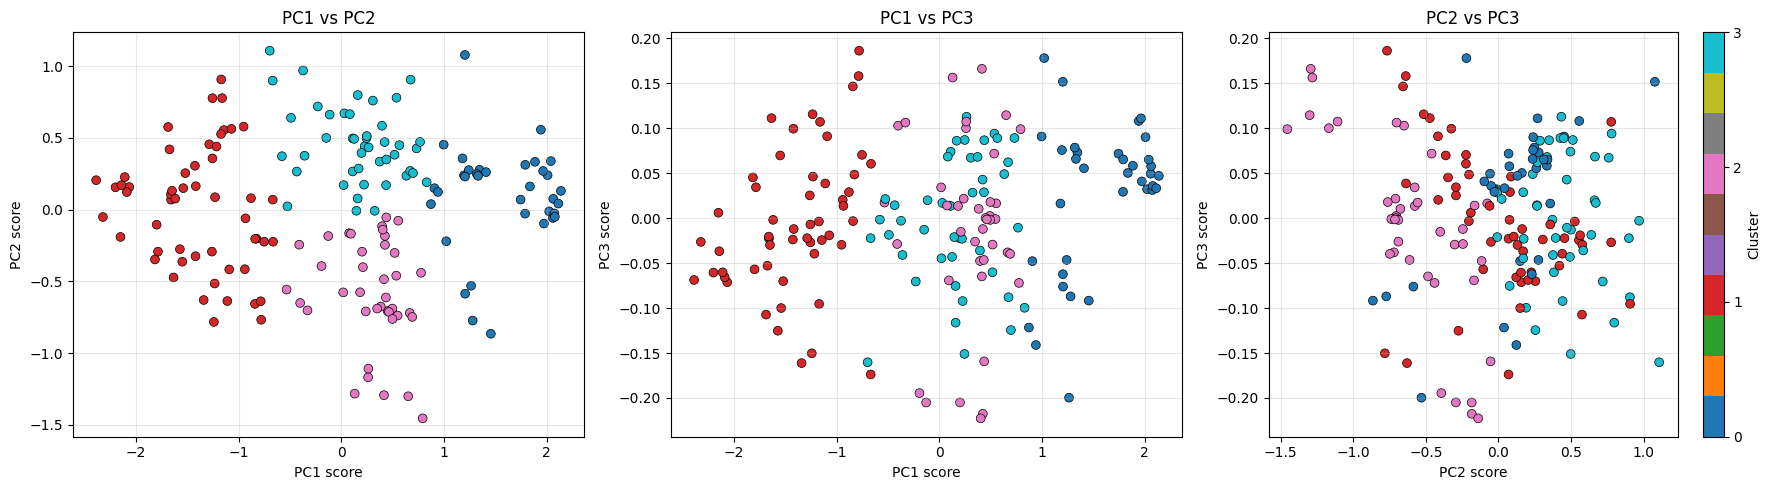


STEP 7: Cluster inspection
Saved: cluster_spectra.png
Saved: cluster_centroids.png

STEP 8: Outlier / rare phase detection

Potential outliers / rare phases (2 spectra):
  FeXANES_GT15_super_dark_Fe_14.001 (cluster 1, dist=1.058, threshold=1.037)
  FeXANES_GT5_flakysmooth2_Fe_22.001 (cluster 4, dist=1.095, threshold=1.018)

STEP 9: Exporting results

Saved: pca_results/cluster_assignments.csv

SUMMARY
Total spectra analyzed: 172
Significant PCA components: 4
Optimal clusters (silhouette): 4
  Cluster 1: 35 spectra
  Cluster 2: 53 spectra
  Cluster 3: 40 spectra
  Cluster 4: 44 spectra
Outlier spectra: 2

All outputs saved to: /Users/christiandewey/Code/GP17-sediments/pca_results


In [24]:
# ============================================================
# MAIN PIPELINE
# ============================================================

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 1. Load data
print("=" * 60)
print("STEP 1: Loading spectra")
print("=" * 60)

groups = load_ascii_spectra(SPECTRA_DIR)

if len(groups) < 3:
    raise ValueError(f"Need at least 3 spectra for PCA, got {len(groups)}")

# 2. Build matrix
print("\n" + "=" * 60)
print("STEP 2: Building spectral matrix")
print("=" * 60)
if PCA_REGION == "xanes":
    x_grid, matrix, names = build_xanes_matrix(groups, E_MIN, E_MAX)
else:
    x_grid, matrix, names = build_exafs_matrix(groups)

# 3. Quality screening
print("\n" + "=" * 60)
print("STEP 3: Quality screening")
print("=" * 60)
matrix, names, quality_mask = screen_spectra(matrix, names)

# 4. PCA
print("\n" + "=" * 60)
print("STEP 4: PCA")
print("=" * 60)
pca_result = run_pca(x_grid, matrix, names)

# Determine number of components
if N_COMPONENTS is not None:
    n_components = N_COMPONENTS
    print(f"Using manual override: {n_components} components")
elif ind_min > len(names) // 2:
    # IND failed (minimum at near-max components) — fall back to scree plot heuristic
    # Use the number of components needed to reach 95% cumulative variance
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances)
    n_components = int(np.argmax(cumvar >= 0.95)) + 1
    print(f"IND minimum unreliable ({ind_min}). Using 95% variance cutoff: {n_components} components")
else:
    n_components = ind_min
    print(f"Number of significant components (IND): {n_components}")

scores = (pca_result.ydat - pca_result.mean) @ pca_result.components[:n_components].T

# 5. Target transformation
print("\n" + "=" * 60)
print("STEP 5: Target transformation")
print("=" * 60)
tt_results = run_target_transform(pca_result, REFERENCE_PATHS, n_components)

# 6. Clustering
print("\n" + "=" * 60)
print("STEP 6: Clustering")
print("=" * 60)
labels, best_k, km_model = run_clustering(scores, names, n_components, OUTPUT_DIR)
if FORCE_K is not None:
    from sklearn.cluster import KMeans
    best_k = FORCE_K
    km_forced = KMeans(n_clusters=best_k, n_init=20, random_state=42)
    labels = km_forced.fit_predict(scores)
    print(f"Overriding silhouette choice — using k={best_k}")


# Regenerate score scatter plots with FORCE_K labels
n_pairs = min(3, n_components - 1)
fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
if n_pairs == 1:
    axes = [axes]

pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
for ax, (i, j) in zip(axes, pc_pairs):
    scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                         cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
    ax.set_xlabel(f"PC{i+1} score")
    ax.set_ylabel(f"PC{j+1} score")
    ax.set_title(f"PC{i+1} vs PC{j+1}")
    ax.grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[-1], label="Cluster", ticks=range(best_k))
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "score_scatter_k4.png", dpi=150, bbox_inches="tight")
plt.show()


# 7. Inspect clusters
print("\n" + "=" * 60)
print("STEP 7: Cluster inspection")
print("=" * 60)
centroids = plot_cluster_spectra(x_grid, matrix, names, labels, best_k, OUTPUT_DIR)

# 8. Outlier detection
print("\n" + "=" * 60)
print("STEP 8: Outlier / rare phase detection")
print("=" * 60)
outliers = find_outliers(scores, names, labels)

# 9. Export
print("\n" + "=" * 60)
print("STEP 9: Exporting results")
print("=" * 60)
df = export_results(names, labels, scores, n_components, outliers, OUTPUT_DIR)

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Total spectra analyzed: {len(names)}")
print(f"Significant PCA components: {n_components}")
print(f"Optimal clusters (silhouette): {best_k}")
for ci in range(best_k):
    n_in = (labels == ci).sum()
    print(f"  Cluster {ci+1}: {n_in} spectra")
print(f"Outlier spectra: {len(outliers)}")
print(f"\nAll outputs saved to: {OUTPUT_DIR.resolve()}")